# Locating longitudinal-transverse correlations in transverse phase space 

The goal of this notebook is to identify the "width" of the measured longitudinal-transverse correlation in the phase space distribution of the BTF bunch at the first emittance station. We will look at the energy distribution of particles within a boundary in 4D transverse phase space.

In [1]:
import sys
import os
from os.path import join
import importlib
import numpy as np
import h5py
import itertools
from tqdm.notebook import tqdm
from tqdm.notebook import trange
from plotly import graph_objects as go
from matplotlib import pyplot as plt
from ipywidgets import interactive
from ipywidgets import widgets
import proplot as pplt

sys.path.append('../../')
from tools import plotting as mplt
from tools import utils
from tools.utils import project
from tools import analysis as ba

In [2]:
pplt.rc['grid'] = False
pplt.rc['cmap.discrete'] = False
pplt.rc['cmap.sequential'] = 'viridis'
pplt.rc['figure.facecolor'] = 'white'

## Load data 

In [3]:
folder = '_saved/2021-12-03-VS06/'

In [4]:
info = utils.load_pickle(join(folder, 'info.pkl'))
info

{'acts': ['y_PositionSync', 'xp_PositionSync', 'x_PositionSync'],
 'datadir': '/Diagnostics/Data/Measurements/scan-xxpy-image-ypdE/2021-12-03/',
 'filename': 'merged2-211203151919-211203192701-scan-xxpy-image-ypdE',
 'variables': {'y1': {'pvname': 'ITSF_Diag:Slit_HZ04',
   'center': 14.5,
   'distance': 22.0,
   'steps': 32,
   'min': -50.0,
   'max': 50.0},
  'x2': {'pvname': 'ITSF_Diag:Slit_VT06',
   'center': 13.5,
   'distance': 13.0,
   'steps': 32,
   'min': -50.0,
   'max': 50.0},
  'x1': {'pvname': 'ITSF_Diag:Slit_VT04',
   'center': 13.0,
   'distance': 17.0,
   'steps': 32,
   'min': -50.0,
   'max': 50.0}},
 'M': array([[1.  , 0.  , 0.  ],
        [0.  , 1.  , 0.65],
        [0.  , 0.  , 1.  ]]),
 'ndim': 3,
 'cam': 'cam06',
 'cam_zoom': 1.0,
 'cam_pix2mm_y': 0.0659,
 'cam_pix2mm_x': 0.0659,
 'cam_shape': (258, 346),
 'signal_thresh': 0.0017,
 'image_crop_edges': {'x1': 45, 'x2': 300, 'y1': 20, 'y2': 237},
 'image_offset': 0.0,
 'noise_icenter': 17714,
 'image_thresh': 1450.

In [5]:
filename = info['filename']
coords = utils.load_stacked_arrays(join(folder, f'coords_{filename}.npz'))
shape = tuple([len(c) for c in coords])
print('shape:', shape)

shape: (36, 52, 36, 80, 93)


In [6]:
f = np.memmap(join(folder, f'f_{filename}.mmp'), shape=shape, dtype='float', mode='r')

Crop the 5D array.

In [7]:
dims = ["x", "x'", "y", "y'", "w"]
units = ["mm", "mrad", "mm", "mrad", "MeV"]
dims_units = [f'{d} [{u}]' for d, u in zip(dims, units)]
prof_kws = dict(lw=0.5, alpha=0.7, color='white', scale=0.12)

In [8]:
prof = []
for i in range(5):
    p = utils.project(f, i)
    p = p / np.sum(p)
    prof.append(p)

In [9]:
for i in range(5):
    coords[i] = coords[i] - np.average(coords[i], weights=prof[i]) 

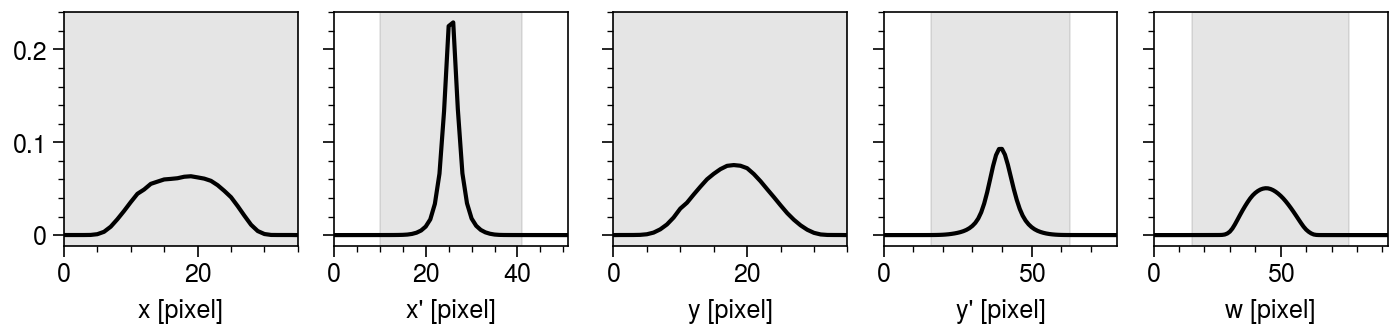

In [10]:
crop = (
    (0, f.shape[0]),
    (10, f.shape[1] - 10),
    (0, f.shape[2]),
    (16, f.shape[3] - 16),
    (15, f.shape[4] - 15),
)

fig, axes = pplt.subplots(ncols=5, figwidth=7, spanx=False, figheight=None)
for i, ax in enumerate(axes):
    ax.plot(prof[i], color='black')
    ax.axvspan(crop[i][0], crop[i][1] - 1, color='black', alpha=0.1)
    ax.format(xlabel=dims[i] + ' [pixel]')
# axes.format(yscale='log')
plt.show()

In [11]:
ind = tuple([slice(c[0], c[1]) for c in crop])
f = f[ind]
coords = [c[ind[i]] for i, c in enumerate(coords)]

Clip small negative values.

In [12]:
f_max = np.max(f)
f_min = np.min(f)
if f_min < 0.0:
    print(f'min(f) = {f_min}')
    print('Clipping to zero.')
    f = np.clip(f, 0.0, None)

min(f) = -6.225430075510691e-15
Clipping to zero.


In [13]:
f = f / f_max

## Rectangular slice

### 2D projections 

First view the 2D projections at integer slices. 

In [ ]:
mplt.interactive_proj2d(f, coords=coords, dims=dims, units=units, slice_type='int')

And at range slices.

In [ ]:
mplt.interactive_proj2d(f, coords=coords, dims=dims, units=units,
                        slice_type='range')

In [ ]:
frac_thresh = 10.0**-3.0

And all 2D projections.

In [ ]:
axes = mplt.corner(
    f,
    coords=coords,
    diag_kind='None',
    labels=dims_units,
    norm='log', 
    handle_log='floor',
    cbar=True,
    frac_thresh=10.0**-3.0,
    prof='edges',
    prof_kws=dict(lw=0.5, alpha=0.7, color='white', scale=0.12),
    linewidth=0, rasterized=True,
)
axes.format(xlabel_kw=dict(fontsize='large'), ylabel_kw=dict(fontsize='large'))
# plt.savefig('_output/corner_VS06')

### 1D projections 

In [ ]:
mplt.interactive_proj1d(f, coords=coords, dims=dims, units=units, default_ind=4,
                        slice_type='int')

In [ ]:
mplt.interactive_proj1d(f, coords=coords, dims=dims, units=units, default_ind=4,
                        slice_type='range')

In [ ]:
# pplt.rc['pdf.fonttype'] = 42

In [ ]:
_ind = [np.argmin(np.abs(c)) for c in coords]

fig, axes = pplt.subplots(ncols=4, figwidth=4.5, figheight=1.35)
axes.format(xlabel="w [MeV]", yticklabels=[], xlim=(-0.065, 0.065))
for i, ax in enumerate(axes):
    idx = utils.make_slice(4, np.arange(i + 1), _ind[:i+1])
    
    frac = np.sum(f[idx]) / np.sum(f)
    
    pw = project(f[idx], 3 - i)
    pw = pw / np.sum(pw)
    ax.bar(coords[4], pw, color='black', width=1)
    title = ""
    for j in range(i + 1):
        title += r"${} \approx$".format(dims[j])
    title += "0"
    title += f"\n({100.0*frac:.2f}%)"
    ax.format(title=title, title_kw=dict(fontsize='medium'))
axes.format(ylim=(0.0, axes[0].get_ylim()[1]), 
            xspineloc='bottom', yspineloc='neither', 
            # ylabel='Density'
           )
# for png in [False, True]:
#     figname = '_output/w_slices'
#     if png:
#         figname += '.png'
#     plt.savefig(figname)

## Contour slice

Select only those pixels above a threshold — within a contour — in 4D phase space. An example of contours in 2D phase space.

In [ ]:
f2d = project(f, (2, 3))
f2d = f2d / np.max(f2d)

fig, ax = pplt.subplots()
mplt.plot_image(
    f2d, x=coords[2], y=coords[3], ax=ax,
    contour=True, 
    contour_kws=dict(
        labels=True, 
        color='white',
        lw=0.4,
        alpha=1,
        levels=(0.001, 0.01, 0.1, 0.5, 1.0),
    ),
    colorbar=True,
)
ax.format(xlabel="y [mm]", ylabel="yp [mrad]")
# plt.savefig('contour_yyp.png')
plt.show()

Project the distribution onto 4D transverse phase space.

In [ ]:
ftr = project(f, axis=(0, 1, 2, 3))
ftr = ftr / np.max(ftr)

View the distribution of pixel values in the array.

In [ ]:
fig, ax = pplt.subplots()
ax.hist(ftr.ravel(), bins=20, color='black')
ax.format(yscale='log', ylabel='Count', xlabel='4D pixel value')
plt.show()

### Energy distribution 

Plot the energy distribution of a shrinking 4D phase space volume. The volume is defined by a contour in 4D phase space.

In [ ]:
def energy_proj(f, level=0.5, ftr=None, normalize=True, return_frac=False):
    if ftr is None:
        ftr = np.sum(f, axis=-1)
    idx = np.where(ftr > level)
    frac = np.sum(ftr[idx]) / np.sum(ftr)
    pw = np.sum(f[idx], axis=0)
    if normalize:
        pw = pw / np.sum(pw)
    if return_frac:
        return pw, frac
    return pw

In [ ]:
def update(level):
    pw, frac = energy_proj(f, level, ftr=ftr, normalize=True, return_frac=True)
    fig, ax = pplt.subplots(figsize=(4, 1.5))
    ax.format(xlabel=dims_units[4], title=f'frac = {frac:.2f}')
    ax.bar(coords[4], pw, color='black')
    plt.show()
    
interactive(update, level=(0.0, 0.99, 0.01))

Uncomment cells below for various plots of the same data.

In [ ]:
n = 20
levels = np.linspace(0.9, 0.0, n)

pws, fracs = [], []
for level in levels:
    pw, frac = energy_proj(f, level, ftr=ftr, normalize=True, return_frac=True)
    pws.append(pw)
    fracs.append(frac)
pws = pws / np.max(pws)

In [ ]:
fig, ax = pplt.subplots()
ax.plot(
    levels[::-1], fracs[::-1], color='black',
    marker='.', lw=0,
)
ax.format(xlabel="Fractional threshold in x-x'-y-y'", ylabel='Fraction of particles', xlim=(-0.02, 1.0))

In [ ]:
fig, ax = pplt.subplots(figsize=(4, 1.75))
ax.pcolormesh(coords[4], levels[::-1], pws[::-1],
              colorbar=True, colorbar_kw=dict(label='Density (arb. units)', width=0.1))
ax.format(xlabel='Energy [MeV]', ylabel='4D contour level')
plt.show()

In [ ]:
cmap = pplt.Colormap('fire_r', left=0.0, right=0.9)
# cmap = pplt.Colormap('crest', left=0.0, right=1.0)

fig, ax = pplt.subplots(figsize=(4, 1.75))
ax.plot(pws[::-1].T, cycle=cmap, lw=1, colorbar=True, 
        colorbar_kw=dict(values=levels[::-1], label='4D contour level'))
plt.show()

In [ ]:
fig, ax = pplt.subplots(figsize=(4.5, 1.55))

alpha = 0.3
color = 'red6'
ax2 = ax.alty(color=color)
ax2.format(ylabel='Fraction of beam', 
           yscale='log', 
           ylim=(0.001, 1.0))

_levels = np.linspace(0.0, 0.95, 35)
_fracs = [energy_proj(f, _level, ftr=ftr, normalize=True, return_frac=True)[1]
          for _level in _levels]
ax2.plot(_levels[::-1], _fracs[::-1], zorder=0, color=color, alpha=alpha, lw=1.25)

for level, pw in zip(levels, pws):
    ax.plotx(coords[4], level + 0.045 * pw, 
             # color='black', alpha=0.3,
             color='black', alpha=1,
             zorder=999999)
ax.format(ylim=(-0.09, 0.09), xlim=(-0.03, 0.97))

ax.format(
    ylabel='w [MeV]', 
    xlabel="Fractional threshold in x-x'-y-y'",
)

_levels = np.linspace(0.95, 0.0, 200)
_fracs = [energy_proj(f, _level, ftr=ftr, normalize=True, return_frac=True)[1] for _level in _levels]

# for png in [False, True]:
#     figname = f'_output/waterfall'
#     if png:
#         figname += '.png'
#     plt.savefig(figname)

In [ ]:
# Z = pws[::-1]
# X, Y = np.meshgrid(levels[::-1], coords[4], indexing='ij')    
# lines = []
# line_marker = dict(color='black', width=3)
# for x, y, z in zip(X, Y, Z):
#     lines.append(go.Scatter3d(x=x, y=y, z=z, mode='lines', line=line_marker))
# uaxis= dict(
#     gridcolor='rgb(255, 255, 255)',
#     zerolinecolor='rgb(255, 255, 255)',
#     showbackground=True,
#     backgroundcolor='rgb(230, 230,230)',
# )
# layout = go.Layout(
#     width=500,
#     height=500,
#     showlegend=False,
#     scene=dict(
#         xaxis=uaxis, 
#         yaxis=uaxis,
#         zaxis=uaxis,
#     ),
# )
# fig = go.Figure(data=lines, layout=layout)
# fig.show()

In [ ]:
# fig = go.Figure(data=[go.Surface(x=levels[::-1], y=coords[4], z=pws[::-1].T)])
# fig.update_layout(width=500, height=500)
# fig.show()

### Corner plot with slicing

We want to see what the distribution looks like as we slice it. First, plot the 2D projections of the 4D phase space distribution as the boundary is changed, along with the energy distribution of the pixels in the slice.

In [ ]:
def update(log=False, level=0.5):
    global ftr 
    frac = np.sum(ftr[ftr > level]) / np.sum(ftr)
    print(f'frac = {frac:.4f}')
    axes = mplt.corner(
        np.ma.masked_where(ftr < level, ftr),
        coords=coords[:4],
        diag_kind='None',
        labels=dims_units,
        thresh=10.0**-3.0,
        thresh_type='frac',
        fill_value=0.0,
        norm='log' if log else None,
        handle_log='floor',
        prof='edges',
        prof_kws=dict(kind='step', lw=0.4, alpha=0.8),
        linewidth=0,rasterized=True
    )
    pw = energy_proj(f, level, ftr=ftr, normalize=True)
    ax = axes[0, 2]
    for i in range(3):
        for j in range(i + 1):
            axes[i, j]._shared_x_axes.remove(ax)
            axes[i, j]._shared_y_axes.remove(ax)
    ax.axis('on')
    ax.plot(coords[4], pw, color='black')
    ax.format(
        xlim=(np.min(coords[4]), np.max(coords[4])),
        ylim=(0, 0.1),
        xspineloc='bottom', yspineloc='left',
        title='energy projection',
    )
    return axes, frac
    
interactive(update, log=False, level=(0.0, 0.99, 0.01))

In [ ]:
for i, level in enumerate(levels[::-1]):
    axes, frac = update(level=level)
    suptitle = f"threshold = {level:.2f}"
    suptitle += f"\n({100.0 * frac:.2f}% of beam)"
    axes.format(suptitle=suptitle, xlabel_kw=dict(fontsize='large'), ylabel_kw=dict(fontsize='large'))
    plt.savefig(f'_output/corner_slice_{i}.png', dpi=175)
    plt.close()

Save a gif of this figure.

In [ ]:
# def update(level):
#     _ftr = np.ma.masked_where(ftr < level, ftr)
#     _fxxp = project(_ftr, axis=(0, 1))
#     _fyyp = project(_ftr, axis=(2, 3))
#     plot_kws = dict(
#         frac_thresh=frac_thresh,
#         fill_value=0.0,
#         norm=None,
#         handle_log='floor',
#         prof_kws=dict(kind='step', lw=0.4, alpha=0.8),
#     )

#     fig, axes = pplt.subplots(ncols=3, figwidth=6, share=False)
#     for ax, (i, j) in zip(axes[:2], [(0, 1), (2, 3)]):
#         mplt.plot_image(project(_ftr, (i, j)), x=coords[i], y=coords[j], ax=ax, 
#                         # profx=True, profy=True, 
#                         **plot_kws)
#         ax.format(xlabel=dims_units[i], ylabel=dims_units[j])
#     pw = energy_proj(f, level)
#     ax = axes[2]
#     ax.plot(energy_proj(f, level, ftr=ftr, normalize=True), color='black')
#     ax.format(xlabel=dims_units[4], ylim=(0, 0.1), yticks=[])
#     for ax in axes[:2]:
#         ax.format(xlim=0.8*np.array(ax.get_xlim()), ylim=0.5*np.array(ax.get_ylim()))
        
# interactive(update, level=(0.0, 0.99, 0.01))

Next, plot the 2D projections of the 5D distribution as the 4D slice boundary is changed. To slice the array, we compute a 4D mask in the transverse phase space, then copy the mask along the last axis of the array to get a 5D mask. *This works but is very slow...*

In [ ]:
def mask_4d(f, level=0.0, ftr=None):
    """Mask N-D array `f` based on contours of `f.sum(axis=-1)`."""
    if ftr is None:
        ftr = np.sum(f, axis=-1)
    condition = utils.copy_into_new_dim(ftr < level, f.shape[-1])
    return np.ma.masked_where(condition, f)

In [ ]:
def update(log, level):
    axes = mplt.corner(
        mask_4d(f, level, ftr=ftr),
        coords=coords,
        diag_kind='None',
        labels=dims_units,
        thresh=10.0**-3.0,
        thresh_type='frac',
        fill_value=0.0,
        norm='log' if log else None,
        handle_log='floor',
        prof='edges',
        prof_kws=dict(kind='step', lw=0.4, alpha=0.8),
    )
    plt.show()
    
interactive(update, log=False, level=(0.0, 0.99, 0.01))

## Hollow 5D shape 

There is hollowing in the transverse phase space, near the center of the longitudinal phase space. How can we visualize this?

Try radial density plot. We will compute the mean density in nested ellipsoidal shells. This hides some information unless there is perfect ellipsoidal symmetry.

### Test on Gaussian distribution 

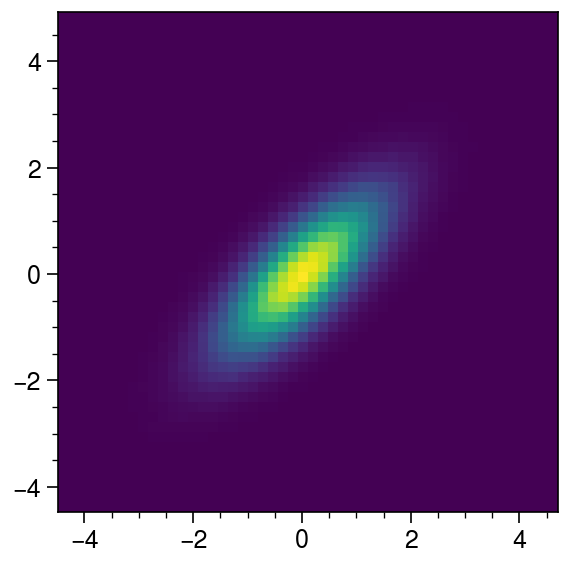

In [14]:
ndim = 2
points = np.random.normal(size=(int(1e6), ndim))
R = np.identity(ndim) 
R += np.random.uniform(low=-2, high=2, size=(ndim, ndim))
points = utils.apply(R, points)

density, edges = np.histogramdd(points, bins=50)
density = density / np.sum(density)
del(points)

_centers = [0.5 * (e[:-1] + e[1:]) for e in edges]
fig, ax = pplt.subplots()
mplt.plot_image(density, x=_centers[0], y=_centers[1], ax=ax)
plt.show()

In [15]:
Sigma, mu = ba.dist_cov(density, _centers)
Sigma_inv = np.linalg.inv(Sigma)

COORDS = np.meshgrid(_centers[0], _centers[1], indexing='ij')

R = np.zeros(density.shape)
for ind in itertools.product(*[range(s) for s in density.shape]):
    vec = np.array([C[ind] for C in COORDS])
    R[ind] = np.sqrt(np.linalg.multi_dot([vec.T, Sigma_inv, vec]))
    
dr = 0.1
rs = np.linspace(0.0, 4.0, 100)
fr = []
for r in rs:
    _density = np.ma.masked_where(np.logical_or(R < r, R > r + dr), density)
    fr.append(np.mean(_density))
fr = np.array(fr)

/tmp/ipykernel_2338224/3765126364.py:17: UserWarning: Warning: converting a masked element to nan.
  fr = np.array(fr)


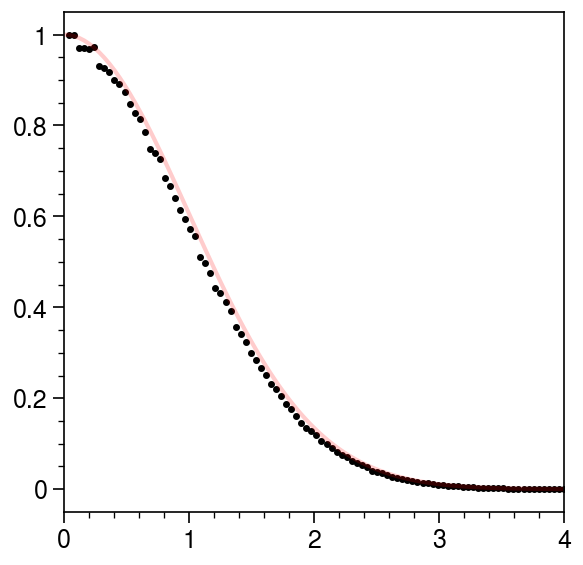

In [19]:
fig, ax = pplt.subplots()
ax.plot(rs, fr / np.nanmax(fr), color='black', marker='.', lw=0, ms=3)
ax.plot(rs, np.exp(-0.5 * rs**2), color='red', alpha=0.2)
plt.show()

### Try on real distribution 

In [49]:
from scipy import special

In [20]:
f[f < 10.0**-3.5] = 0.0

In [22]:
def get_radii(coords, Sigma):
    COORDS = np.meshgrid(*coords, indexing='ij')
    shape = tuple([len(c) for c in coords])
    R = np.zeros(shape)
    Sigma_inv = np.linalg.inv(Sigma)
    for ii in tqdm(np.ndindex(shape)):
        vec = np.array([C[ii] for C in COORDS])
        R[ii] = np.sqrt(np.linalg.multi_dot([vec.T, Sigma_inv, vec]))
    return R

def radial_density(f, R, radii, dr=None):
    if dr is None:
        dr = 0.5 * np.max(R) / (len(R) - 1)
    fr = []
    for r in tqdm(radii):
        f_masked = np.ma.masked_where(np.logical_or(R < r, R > r + dr), f)
        fr.append(np.mean(f_masked))
    return np.array(fr)

In [50]:
def proj_radial_density(f, axis, nr, dr=None):
    # Project the distribution onto the specified axis.
    _f = utils.project(f, axis)
    
    # Compute the covariance matrix.
    _coords = [coords[i] for i in axis]
    Sigma, mu = ba.dist_cov(_f, _coords, disp=True)
    
    # Compute the radii in normalized space.
    R = get_radii(_coords, Sigma)
    
    # Compute the radial density in normalized space.
    radii = np.linspace(0.0, np.max(R), nr)
    fr = radial_density(_f, R, radii, dr=None)
    return fr, radii

axis = (0, 1, 2, 3)
Forming (36, 32, 36, 48) meshgrid...
Averaging...


100%|██████████| 1/1 [00:00<00:00, 31.97it/s]

100%|██████████| 2/2 [00:00<00:00, 40.97it/s]

100%|██████████| 4/4 [00:00<00:00, 12.89it/s]

Done.


0it [00:00, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

/tmp/ipykernel_2338224/4018591001.py:18: UserWarning: Warning: converting a masked element to nan.
  return np.array(fr)


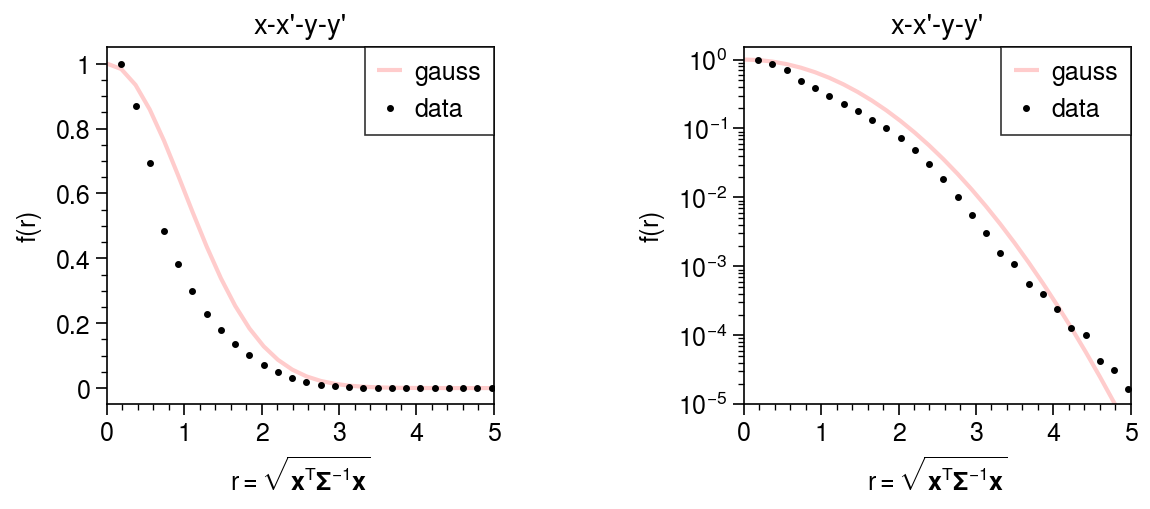

axis = (0, 1, 2, 4)
Forming (36, 32, 36, 63) meshgrid...
Averaging...


100%|██████████| 1/1 [00:00<00:00, 23.22it/s]

100%|██████████| 3/3 [00:00<00:00, 31.12it/s]

100%|██████████| 4/4 [00:00<00:00, 11.52it/s]

Done.


0it [00:00, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

/tmp/ipykernel_2338224/4018591001.py:18: UserWarning: Warning: converting a masked element to nan.
  return np.array(fr)


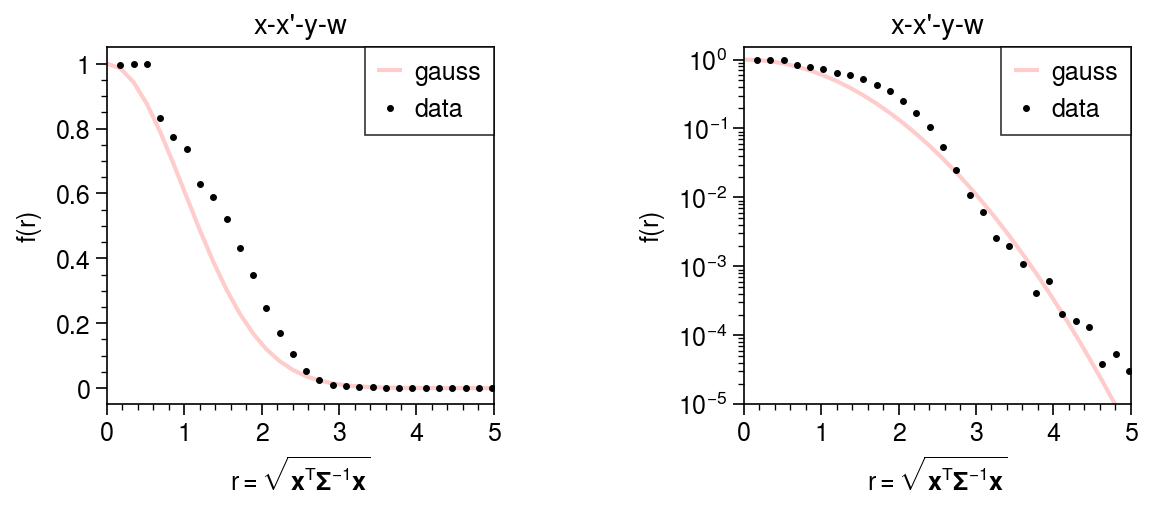

axis = (0, 1, 3, 4)
Forming (36, 32, 48, 63) meshgrid...
Averaging...


100%|██████████| 1/1 [00:00<00:00, 17.69it/s]

100%|██████████| 3/3 [00:00<00:00, 21.94it/s]

100%|██████████| 4/4 [00:00<00:00,  8.30it/s]


Done.


0it [00:00, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

/tmp/ipykernel_2338224/4018591001.py:18: UserWarning: Warning: converting a masked element to nan.
  return np.array(fr)


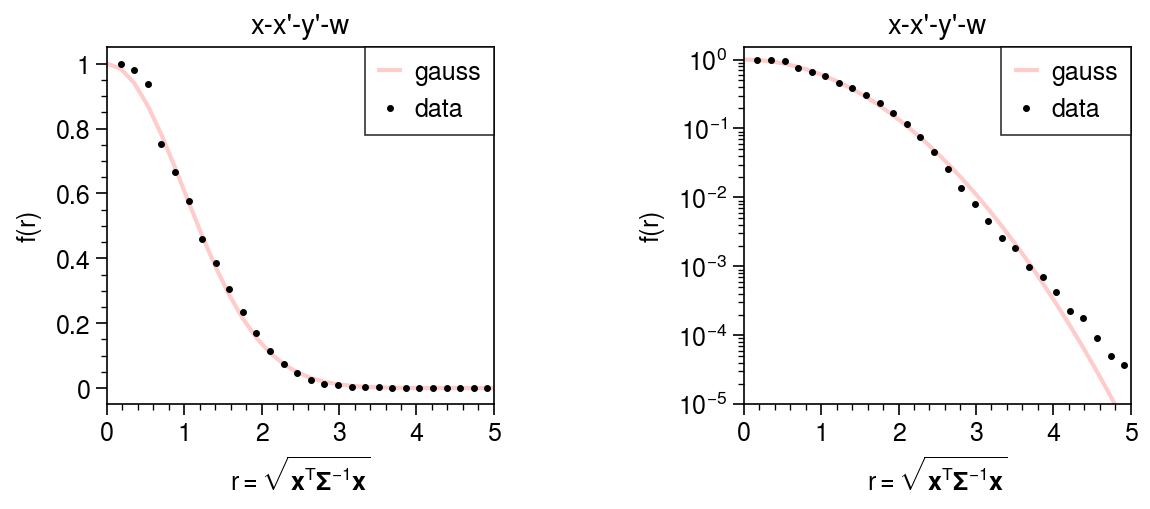

axis = (0, 2, 3, 4)
Forming (36, 36, 48, 63) meshgrid...
Averaging...


100%|██████████| 1/1 [00:00<00:00, 16.69it/s]

100%|██████████| 3/3 [00:00<00:00, 19.64it/s]

100%|██████████| 4/4 [00:00<00:00,  7.60it/s]

Done.


0it [00:00, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

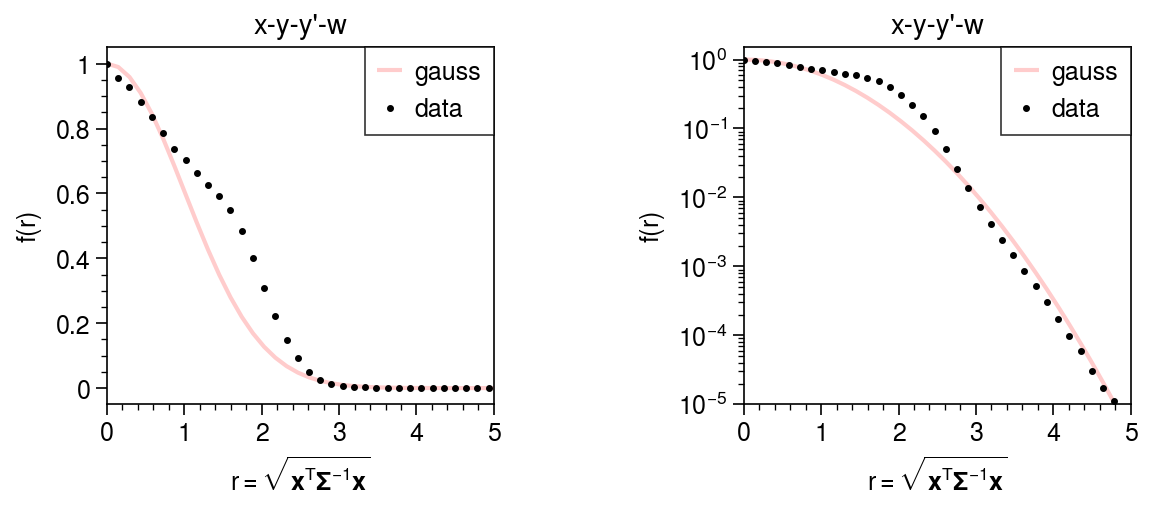

axis = (1, 2, 3, 4)
Forming (32, 36, 48, 63) meshgrid...
Averaging...


100%|██████████| 1/1 [00:00<00:00, 18.44it/s]

100%|██████████| 3/3 [00:00<00:00, 22.52it/s]

100%|██████████| 4/4 [00:00<00:00,  8.61it/s]


Done.


0it [00:00, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

/tmp/ipykernel_2338224/4018591001.py:18: UserWarning: Warning: converting a masked element to nan.
  return np.array(fr)


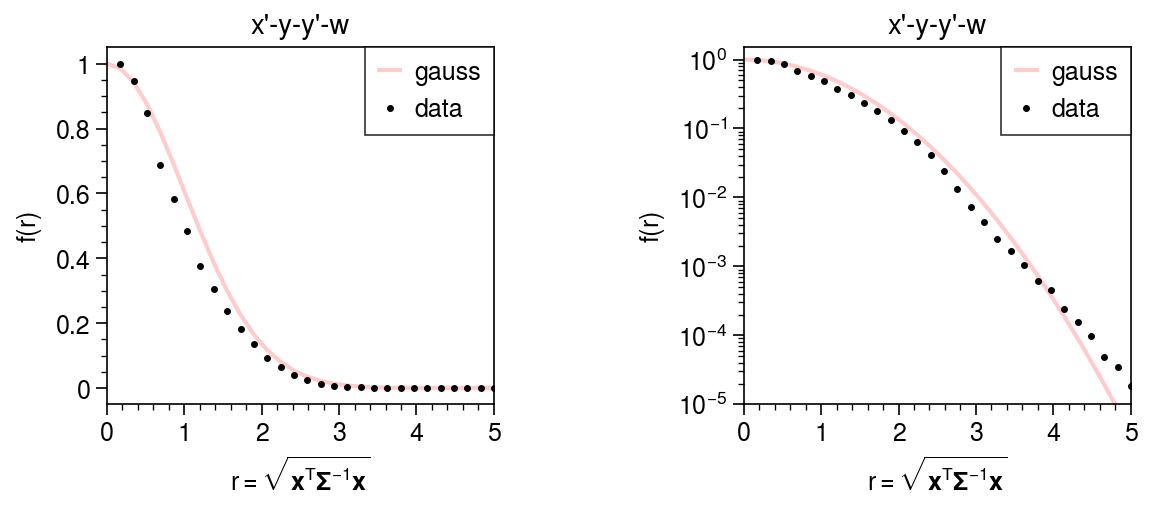

In [57]:
ndim = 4  # number of dimensions in projected array
nr = 70  # number of radial points
for axis in itertools.combinations([0, 1, 2, 3, 4], ndim):
    print('axis =', axis)
    
    # Compute the approximate radial density, normalized so that max(fr) = 1.
    fr, radii = proj_radial_density(f, axis, nr)
    fr = fr / np.nanmax(fr)
    
    # Plot on top of a Gaussian which is normalized in the same way.
    fig, axes = pplt.subplots(ncols=2, figwidth=5.75, figheight=2.55, share=False, space=10)
    for ax in axes:
        alpha = 0.2
        ax.plot(radii, np.exp(-0.5 * radii**2), color='red', alpha=alpha, label='gauss')
        # ax.plot(rs, [float(r <= 2.0) for r in rs], color='blue', alpha=alpha, label='uniform')
        ax.plot(
            radii, fr, color='black', label='data',
            marker='.', lw=0, ms=3,
        )
        ax.legend(ncols=1, loc='upper right', handlelength=1)
    axes.format(xlim=(0.0, 5.0))
    axes[1].format(yscale='log', yformatter='log')
    axes[1].format(ymin=1e-5, ymax=1.5)
    
    title = "-".join([dims[i] for i in axis])
    axes.format(xlabel=r"$r = \sqrt{\mathbf{x}^T\mathbf{\Sigma}^{-1}\mathbf{x}}$", 
                ylabel=r"$f(r)$", title=title)
    plt.savefig(f'_output/{title}.png')
    plt.show()